In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import importlib
import os
import random
import fnmatch
import datetime
import pickle


import numpy as np
np.set_printoptions(formatter={'float_kind' : lambda x : "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

print(f'tf.__version__: {tf.__version__}')
print(f'.keras.__version__: {tensorflow.keras.__version__}')

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__: 2.9.2
.keras.__version__: 2.9.0


image_path : /content/drive/MyDrive/artificial_control/data/train_2_00816_090.png
steering_Angle : 90


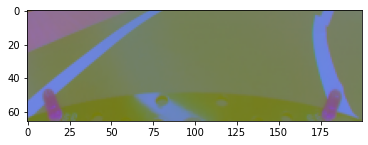

In [3]:

data_dir = "/content/drive/MyDrive/artificial_control/data"
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
  if fnmatch.fnmatch(filename, pattern):
    image_paths.append(os.path.join(data_dir,filename))
    angle = int(filename[-7:-4])
    steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path : %s" % image_paths[image_index])
print("steering_Angle : %d" % steering_angles[image_index])
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([1344.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 5553.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1988.0000]),
 array([45.0000, 48.6000, 52.2000, 55.8000, 59.4000, 63.0000, 66.6000,
        70.2000, 73.8000, 77.4000, 81.0000, 84.6000, 88.2000, 91.8000,
        95.4000, 99.0000, 102.6000, 106.2000, 109.8000, 113.4000, 117.0000,
        120.6000, 124.2000, 127.8000, 131.4000, 135.0000]),
 <a list of 25 Patch objects>)

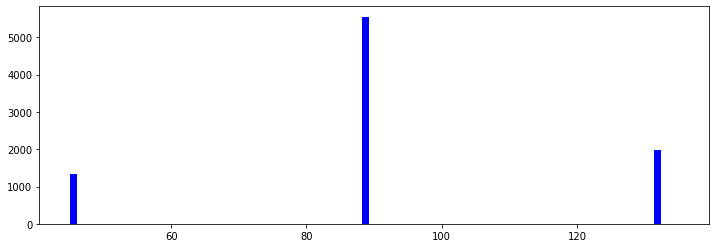

In [4]:
num_of_bins = 25
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize = (12, 4))
axes.hist(df['Angle'], bins = num_of_bins, width = 1, color = 'blue')

Training data : 7108
Validation data : 1777


Text(0.5, 1.0, 'Validation Data')

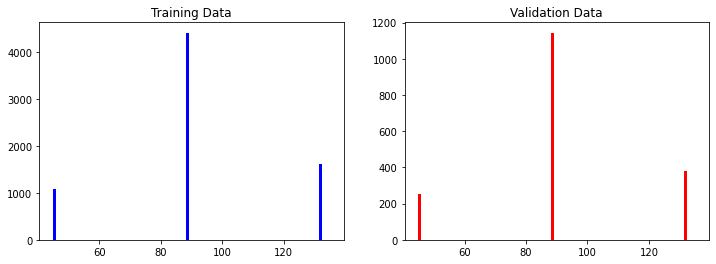

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size = 0.2)
print("Training data : %d\nValidation data : %d" % (len(X_train), len(X_valid)))

fig, axes = plt.subplots(1,2, figsize = (12, 4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color = 'blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins = num_of_bins, width = 1, color = 'red')
axes[1].set_title('Validation Data')

(66, 200, 3)


Text(0.5, 1.0, 'processed')

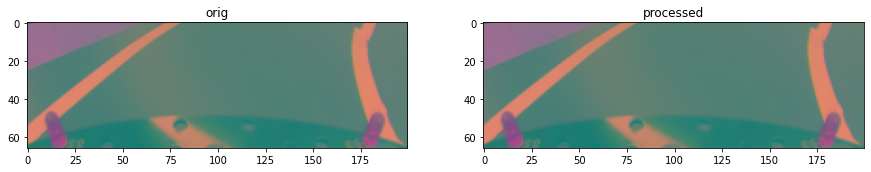

In [6]:
def my_imread(image_path):
  image = cv2.imread(image_path)
  return image

def img_preprocess(image):
  image = image / 255
  return image

fig, axes = plt.subplots(1, 2, figsize=(15,10))
image_orig = my_imread(image_paths[image_index])
print(image_orig.shape)
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

In [7]:
def nvidia_model():
    model = Sequential(name = 'Nvidia_Model')

    model.add(Conv2D(24, (5,5), strides = (2,2), input_shape = (66, 200, 3), activation = 'elu'))
    model.add(Conv2D(36, (5,5), strides = (2,2), activation = 'elu'))
    model.add(Conv2D(48, (5,5), strides = (2,2), activation = 'elu'))
    model.add(Conv2D(64, (3,3), activation = 'elu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), activation = 'elu'))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dense(10, activation = 'elu'))

    model.add(Dense(1))
    
    optimizer = Adam(lr = 1e-3)
    model.compile(loss = 'mse', optimizer = optimizer)

    return model

model = nvidia_model()
print(model.summary())


Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 dropout (Dropout)           (None, 3, 20, 64)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)             

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


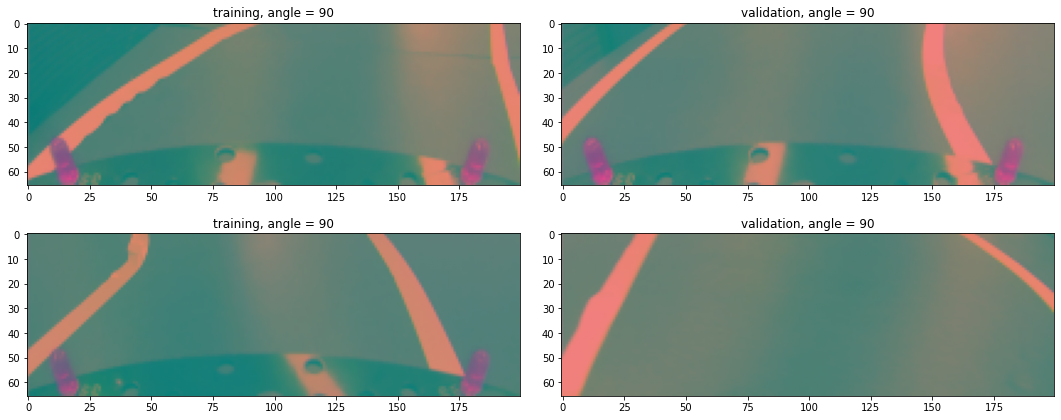

In [8]:
def image_data_generator(image_paths, steering_angles, batch_size):
  while True:
    batch_images = []
    batch_streering_angles = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      image_path = image_paths[random_index]
      image = my_imread(image_paths[random_index])
      steering_angle = steering_angles[random_index]

      image = img_preprocess(image)
      batch_images.append(image)
      batch_streering_angles.append(steering_angle)
    
    yield(np.asarray(batch_images), np.asarray(batch_streering_angles))

ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize = (15,6))
fig.tight_layout()

for i in range(nrow):
  axes[i][0].imshow(X_train_batch[i])
  axes[i][0].set_title("training, angle = %s" % y_train_batch[i])
  axes[i][1].imshow(X_valid_batch[i])
  axes[i][1].set_title("validation, angle = %s" % y_valid_batch[i])                                                            

In [9]:
  model_output_dir = "/content/drive/MyDrive/artificial_control/model"

  checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, 'lane_navigation_check.h5'), 
                                                                 verbose=1, save_best_only =True)

  history = model.fit(image_data_generator(X_train, y_train, batch_size=100), steps_per_epoch=300, epochs=100, 
                                                   validation_data=image_data_generator(X_valid, y_valid, batch_size=100),
                                                   validation_steps=200, verbose=1, shuffle=1, callbacks = [checkpoint_callback])

  model.save(os.path.join(model_output_dir, 'lane_navigation_final.h5'))

  history_path = os.path.join(model_output_dir, 'history.pickle')

  with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 890.0156
Epoch 1: val_loss improved from inf to 672.98022, saving model to /content/drive/MyDrive/artificial_control/model/lane_navigation_check.h5
300/300 [==============================] - 129s 399ms/step - loss: 890.0156 - val_loss: 672.9802
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 502.7968
Epoch 2: val_loss improved from 672.98022 to 301.51044, saving model to /content/drive/MyDrive/artificial_control/model/lane_navigation_check.h5
300/300 [==============================] - 118s 394ms/step - loss: 502.7968 - val_loss: 301.5104
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 320.1600
Epoch 3: val_loss improved from 301.51044 to 261.52039, saving model to /content/drive/MyDrive/artificial_control/model/lane_navigation_check.h5
300/300 [==============================] - 119s 399ms/step - loss: 320.1600 - val_loss: 261.5204
Epoch 4/10
300/300 [=======================

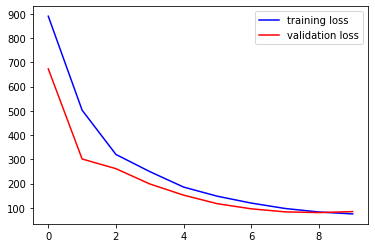

In [10]:
history.history

history_path = os.path.join(model_output_dir, 'history.pickle')

with open(history_path, 'rb') as f:
  history = pickle.load(f)


history
plt.plot(history['loss'], color = 'blue')
plt.plot(history['val_loss'], color = 'red')
plt.legend(['training loss', 'validation loss'])

4/4 [==============================] - 0s 6ms/step
mse = 8.4e+01
r_squared = 87.24%



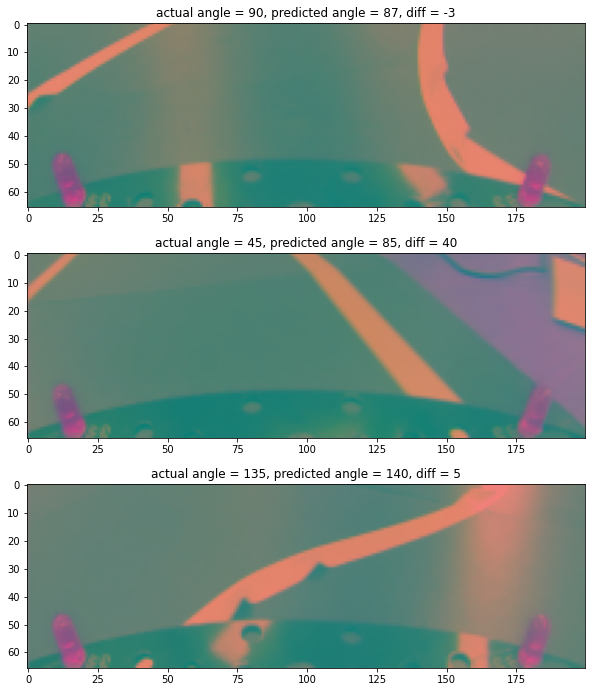

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
  mse = mean_squared_error(Y_true, Y_pred)
  r_squared = r2_score(Y_true, Y_pred)

  print(f'mse = {mse:.2}')
  print(f'r_squared = {r_squared:.2%}')
  print()

def predict_and_summarize(X, Y):
  model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
  Y_pred = model.predict(X)
  summarize_prediction(Y, Y_pred)
  return Y_pred

n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 3
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10,4 * n_tests_show))
for i in range(n_tests_show):
  axes[i].imshow(X_test[i])
  axes[i].set_title(f"actual angle = {y_test[i]}, predicted angle = {int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")